In [2]:
import PARAMS as P
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import experiment
from model import *

In [3]:
rho = 1.0
sigma = 0.1
delta = 0.01
c = 1.0
C = 1000
print("2k < min {d, T}: ", 2*P.k < min(P.d, P.nT))
n1_bound = C * rho**4 * (P.d + np.log(P.nT / delta))
print(f"n1 >> rho^4 (d + log(T/delta))\n <=> {P.n1} > {n1_bound: .0f}:", P.n1 > n1_bound)
n2_bound = C * rho**4 * (P.k + np.log(1 / delta))
print(f"n2 >> rho^4 (k + log(1/delta))\n <=> {P.n2} > {n2_bound: .0f}:", P.n2 > n2_bound)
print(c * P.n1 > P.n2)

2k < min {d, T}:  True
n1 >> rho^4 (d + log(T/delta))
 <=> 50000 >  47090: True
n2 >> rho^4 (k + log(1/delta))
 <=> 5000 >  9605: False
True


In [207]:
configs = {
    "d": 40,
    "k": 5,
    "n1": 50000,
    "n2": 5000,
    "nT": 12,
    "rho": 1.0,
    "sigma": 0.1,
    "delta": 0.01,
    "c": 1.0,
    "A1": True,
    "A2": True,
    "A3": True,
    "A4": True,
}

In [210]:
assumptions_check(configs)

NameError: name 'assumptions_check' is not defined

In [3]:
assumptions_check(configs)
exp = experiment.Experiment(configs)
exp.instantiate()

In [6]:
model = MTLDLR(configs)
source_optim = torch.optim.Adam(model.parameters(), lr=0.01)
source_criterion = torch.nn.MSELoss()
source_X = [t.X for t in exp.source_tasks]
source_y = torch.cat([t.y for t in exp.source_tasks])

In [7]:
for epoch in range(500):
    source_optim.zero_grad()
    prediction = torch.cat(model(source_X))
    loss = source_criterion(prediction, source_y)
    loss.backward()
    source_optim.step()
    if (epoch == 0) or (epoch % 50 == 0):
        print(loss)

tensor(7.6619, grad_fn=<MseLossBackward0>)
tensor(2.1393, grad_fn=<MseLossBackward0>)
tensor(0.4396, grad_fn=<MseLossBackward0>)
tensor(0.2355, grad_fn=<MseLossBackward0>)
tensor(0.1577, grad_fn=<MseLossBackward0>)
tensor(0.1132, grad_fn=<MseLossBackward0>)
tensor(0.0876, grad_fn=<MseLossBackward0>)
tensor(0.0705, grad_fn=<MseLossBackward0>)
tensor(0.0565, grad_fn=<MseLossBackward0>)
tensor(0.0440, grad_fn=<MseLossBackward0>)


In [8]:
optimal_B = model.B.detach()
loss_list = []
for _ in range(1000):
    task = exp.generate_task(is_source=False)
    target_model = TaskPredict()
    target_optim = torch.optim.Adam(target_model.parameters(), lr=0.001)
    target_criterion = torch.nn.MSELoss()
    target_X = task.X
    target_y = task.y

    for epoch in range(200):
        target_optim.zero_grad()
        representation = target_X @ optimal_B
        prediction = target_model(representation)
        loss = target_criterion(prediction, target_y)
        loss.backward()
        target_optim.step()
    optimal_prediction = target_X @ exp.B @ exp.target_task.w
    trained_prediction = target_X @ optimal_B @ target_model.w.weight.detach().squeeze()
    loss_list.append(((optimal_prediction - trained_prediction)**2).mean())

In [20]:
target_model = TaskPredict()
target_optim = torch.optim.Adam(target_model.parameters(), lr=0.001)
target_criterion = torch.nn.MSELoss()
optimal_B = model.B.detach()
target_X = exp.target_task.X
target_y = exp.target_task.y

In [21]:
for epoch in range(200):
    target_optim.zero_grad()
    representation = target_X @ optimal_B
    prediction = target_model(representation)
    loss = target_criterion(prediction, target_y)
    loss.backward()
    target_optim.step()
    if (epoch == 0) or (epoch % 10 == 0):
        print(loss)

tensor(3.0728, grad_fn=<MseLossBackward0>)
tensor(2.8411, grad_fn=<MseLossBackward0>)
tensor(2.6227, grad_fn=<MseLossBackward0>)
tensor(2.4183, grad_fn=<MseLossBackward0>)
tensor(2.2277, grad_fn=<MseLossBackward0>)
tensor(2.0509, grad_fn=<MseLossBackward0>)
tensor(1.8875, grad_fn=<MseLossBackward0>)
tensor(1.7366, grad_fn=<MseLossBackward0>)
tensor(1.5975, grad_fn=<MseLossBackward0>)
tensor(1.4696, grad_fn=<MseLossBackward0>)
tensor(1.3520, grad_fn=<MseLossBackward0>)
tensor(1.2440, grad_fn=<MseLossBackward0>)
tensor(1.1449, grad_fn=<MseLossBackward0>)
tensor(1.0541, grad_fn=<MseLossBackward0>)
tensor(0.9709, grad_fn=<MseLossBackward0>)
tensor(0.8947, grad_fn=<MseLossBackward0>)
tensor(0.8251, grad_fn=<MseLossBackward0>)
tensor(0.7616, grad_fn=<MseLossBackward0>)
tensor(0.7036, grad_fn=<MseLossBackward0>)
tensor(0.6509, grad_fn=<MseLossBackward0>)


In [58]:
optimal_B = model.B.detach()
loss_list = []
for _ in range(1000):
    task = exp.generate_task(is_source=False)
    target_model = TaskPredict()
    target_optim = torch.optim.Adam(target_model.parameters(), lr=0.001)
    target_criterion = torch.nn.MSELoss()
    target_X = task.X
    target_y = task.y

    for epoch in range(200):
        target_optim.zero_grad()
        representation = target_X @ optimal_B
        prediction = target_model(representation)
        loss = target_criterion(prediction, target_y)
        loss.backward()
        target_optim.step()
    optimal_prediction = target_X @ exp.B @ exp.target_task.w
    trained_prediction = target_X @ optimal_B @ target_model.w.weight.detach().squeeze()
    loss_list.append(((optimal_prediction - trained_prediction)**2).mean())

tensor(1.4703)

6.689552

In [32]:
loss_list = np.array(loss_list)
print(loss_list.mean())
print(get_bound(P, sigma, delta))

8.211762947458189e-05

In [11]:
loss_list = np.array(loss_list)
print(loss_list.mean())
print(get_bound(P, sigma, delta))

7.302778
8.211762947458189e-05


In [4]:
exp = experiment.Experiment(
    P.d, 
    P.k, 
    P.nT, 
    P.n1, 
    P.n2,
    epsilon=0.001,
    rho=rho,
    sigma=sigma,
    assumptions=[True, False, True, True])
exp.instantiate()

In [13]:
torch.diag(torch.ones(10) * rho**2)[-1][-1]

tensor(0.2500)

In [16]:
ev = np.linspace(1.0, 1.0, 5)
ev[:3]

array([1., 1., 1.])

In [51]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.functional import normalize
def dist(k):
    ev = torch.ones(k)

    # Q, _ = torch.linalg.qr(torch.randn(k, k))

    mean = torch.zeros(k)
    # ev[-1] *= k
    # cov = Q @ torch.diag(torch.tensor(ev)) @ Q.T
    cov = torch.diag(torch.tensor(ev))
    # cov[1,0] = 0.5
    # cov[0,1] = 0.5

    p_t = MultivariateNormal(mean, covariance_matrix=cov)
    return p_t

for T in range(1000, 10000, 1000):
    # for k in range(100, 200, 50):
    k = 2
    l = []
    for t in range(T):
        w_t = dist(k).sample()
        if t % 10 > 6:
            w_t[-1] = 0.0
        elif t % 10 < 3:
            w_t[0] = 0.0
        w_t = normalize(w_t, p=2.0, dim=0)
        l.append(w_t)
    W = torch.stack(l, dim=1)
    U, S, V = torch.linalg.svd(W)
    print(f"k={k}, T={T}", S.max() / S.min())
    print(S.min())
    # print(S.min())
    # print(1/(S.min()**2))

/var/folders/b3/3q8nyx654bg0fc3ndwllyct00000gr/T/ipykernel_15391/1947027822.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cov = torch.diag(torch.tensor(ev))


k=2, T=1000 tensor(1.0087)
tensor(22.2634)
k=2, T=2000 tensor(1.0173)
tensor(31.3512)
k=2, T=3000 tensor(1.0124)
tensor(38.4902)
k=2, T=4000 tensor(1.0149)
tensor(44.3886)
k=2, T=5000 tensor(1.0128)
tensor(49.6802)
k=2, T=6000 tensor(1.0131)
tensor(54.4154)
k=2, T=7000 tensor(1.0035)
tensor(59.0571)
k=2, T=8000 tensor(1.0070)
tensor(63.0253)
k=2, T=9000 tensor(1.0065)
tensor(66.8657)


In [195]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.functional import normalize
def dist(k):
    ev = torch.linspace(1, 10*k, k)
    mean = torch.zeros(k)
    cov = torch.diag(ev)
    p_t = MultivariateNormal(mean, covariance_matrix=cov)
    return p_t

for T in range(1000, 10000, 1000):
    k = 5
    l = []
    for t in range(T):
        w_t = dist(k).sample()
        if t < 800:
            w_t[2:] = 0.0
        w_t = normalize(w_t, p=2.0, dim=0)
        l.append(w_t)
    W = torch.stack(l, dim=1)
    U, S, V = torch.linalg.svd(W)
    print(f"k={k}, T={T}", S.max() / S.min())

k=5, T=1000 tensor(3.7818)
k=5, T=2000 tensor(2.0642)
k=5, T=3000 tensor(2.1609)
k=5, T=4000 tensor(2.1756)
k=5, T=5000 tensor(2.4932)
k=5, T=6000 tensor(2.6059)
k=5, T=7000 tensor(2.8419)
k=5, T=8000 tensor(3.0050)
k=5, T=9000 tensor(3.0397)


In [203]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.functional import normalize
def dist(k):
    ev = torch.linspace(1, 10*k, k)
    mean = torch.zeros(k)
    cov = torch.diag(ev)
    p_t = MultivariateNormal(mean, covariance_matrix=cov)
    return p_t

for T in range(1000, 10000, 1000):
    k = 5
    l = []
    for t in range(T):
        w_t = dist(k).sample()
        if t > 10:
            w_t = l[0]
        w_t = normalize(w_t, p=2.0, dim=0)
        l.append(w_t)
    W = torch.stack(l, dim=1)
    U, S, V = torch.linalg.svd(W)
    print(f"k={k}, T={T}", S.max() / S.min())

k=5, T=1000 tensor(106.2601)
k=5, T=2000 tensor(94.8292)
k=5, T=3000 tensor(211.6446)
k=5, T=4000 tensor(272.7132)
k=5, T=5000 tensor(262.5277)
k=5, T=6000 tensor(436.0368)
k=5, T=7000 tensor(208.9677)
k=5, T=8000 tensor(302.6698)
k=5, T=9000 tensor(288.6148)


In [204]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.functional import normalize
def dist(k):
    ev = torch.linspace(1, 10*k, k)
    mean = torch.zeros(k)
    cov = torch.diag(ev)
    p_t = MultivariateNormal(mean, covariance_matrix=cov)
    return p_t

for T in range(1000, 10000, 1000):
    for k in range(5, 50, 5):
        l = []
        for t in range(T):
            w_t = dist(k).sample()
            if t > 10:
                w_t = l[0]
            w_t = normalize(w_t, p=2.0, dim=0)
            l.append(w_t)
        W = torch.stack(l, dim=1)
        U, S, V = torch.linalg.svd(W)
        print(f"k={k}, T={T}", S.max() / S.min())

k=5, T=1000 tensor(78.4322)
k=10, T=1000 tensor(2838.7205)
k=15, T=1000 tensor(1.1542e+28)
k=20, T=1000 tensor(inf)
k=25, T=1000 tensor(inf)
k=30, T=1000 tensor(21425196.)
k=35, T=1000 tensor(16916234.)
k=40, T=1000 tensor(16803008.)
k=45, T=1000 tensor(21600772.)
k=5, T=2000 tensor(142.1849)
k=10, T=2000 tensor(453.3321)
k=15, T=2000 tensor(1.2061e+22)
k=20, T=2000 tensor(inf)
k=25, T=2000 tensor(inf)
k=30, T=2000 tensor(16812700.)
k=35, T=2000 tensor(17584124.)
k=40, T=2000 tensor(20366806.)
k=45, T=2000 tensor(16941444.)
k=5, T=3000 tensor(111.2439)
k=10, T=3000 tensor(934.6252)
k=15, T=3000 tensor(1.1762e+23)
k=20, T=3000 tensor(inf)
k=25, T=3000 tensor(inf)
k=30, T=3000 tensor(16801842.)
k=35, T=3000 tensor(16812342.)
k=40, T=3000 tensor(16800384.)
k=45, T=3000 tensor(16790354.)
k=5, T=4000 tensor(155.0688)
k=10, T=4000 tensor(1007.5429)
k=15, T=4000 tensor(2.2161e+20)
k=20, T=4000 tensor(inf)


KeyboardInterrupt: 

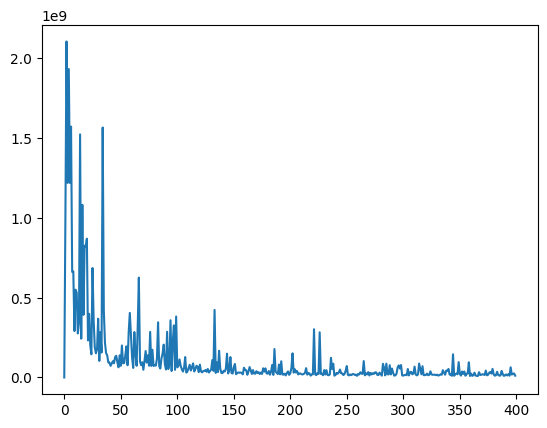

In [201]:
# plot the list l
import matplotlib.pyplot as plt
plt.plot(l)

In [199]:
import torch

# Define the vectors
w1 = torch.tensor([1, 0, 0], dtype=torch.float32)
w2 = torch.tensor([1, 0, 0], dtype=torch.float32)
w3 = torch.tensor([0, 1, 0], dtype=torch.float32)
w4 = torch.tensor([0, 1, 0], dtype=torch.float32)
w5 = torch.tensor([0, 0, 1], dtype=torch.float32)
w6 = torch.tensor([0, 0, 1], dtype=torch.float32)
w7 = torch.tensor([1, 1, 0], dtype=torch.float32)
w8 = torch.tensor([0, 1, 1], dtype=torch.float32)

# Construct the matrix W from these vectors
for i in range(1, 1000, 20):
    W = torch.stack([w1]*i+[w2, w3, w4, w5, w6, w7, w8], dim=1)

    # Compute singular values
    U, S, V = torch.svd(W)

    # Calculate the condition number
    condition_number = S.max() / S.min()

    print("Singular Values of W:", S)
    print("Condition Number of W:", condition_number)


Singular Values of W: tensor([2.2361, 1.7321, 1.4142])
Condition Number of W: tensor(1.5811)
Singular Values of W: tensor([4.8013, 2.1399, 1.5389])
Condition Number of W: tensor(3.1199)
Singular Values of W: tensor([6.5594, 2.1446, 1.5411])
Condition Number of W: tensor(4.2562)
Singular Values of W: tensor([7.9383, 2.1461, 1.5419])
Condition Number of W: tensor(5.1485)
Singular Values of W: tensor([9.1111, 2.1468, 1.5422])
Condition Number of W: tensor(5.9077)
Singular Values of W: tensor([10.1494,  2.1473,  1.5425])
Condition Number of W: tensor(6.5800)
Singular Values of W: tensor([11.0909,  2.1475,  1.5426])
Condition Number of W: tensor(7.1897)
Singular Values of W: tensor([11.9586,  2.1477,  1.5427])
Condition Number of W: tensor(7.7516)
Singular Values of W: tensor([12.7674,  2.1479,  1.5428])
Condition Number of W: tensor(8.2755)
Singular Values of W: tensor([13.5280,  2.1480,  1.5429])
Condition Number of W: tensor(8.7681)
Singular Values of W: tensor([14.2480,  2.1481,  1.5429